In [1]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
from numpy.linalg import norm
from sklearn.cluster import KMeans

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
colors =['r','b','g','c','m','o']
n_colors = 6

In [3]:
###########################################################################
# initialisation ++ le kmeans
#
def initPlusPlus(X,K):
    N,p = np.shape(X)
    C = np.zeros((p,K))
    generator = np.random.default_rng()
    
    index = np.random.choice(N, 1,replace = False)
    liste_index = [index]
    C[:,0] = X[index,:]
    X = np.delete(X,index,0)
    print("k=0 C[k]=",C[:,0],"index=",index)
    k=1
    while k < K:
        #y = np.zeros(X.shape[0])
        NN = X.shape[0]
        dist = np.zeros(NN)
        for n in range(NN):
            D = C[:,:k] - np.repeat(X[n,:],k).reshape(p,k)
            D = np.diag(D @ D.T)
            #y[n] = np.argmin(D)
            dist[n] = np.min(D)

        # calcul des probabilités
        proba = dist/np.sum(dist)
        rand_value = generator.random((1))[0]
        intervals = np.cumsum(proba)
        index =0
        while index < NN:
            if intervals[index]> rand_value:
                break
            index += 1
        # tirage aléatoire selon proba
        C[:,k] = X[index,:]
        X = np.delete(X,index,0)
        print("k=",k,"C[k]=",C[:,k],"index=",index)
        k += 1

    return C

In [4]:
def my_kmeans(X,K,Visualisation=False,Seuil=0.001,Max_iterations = 100):
    
    N,p = np.shape(X)
    iteration = 0        
    Dist=np.zeros((K,N))

    J=np.zeros(Max_iterations+1)
    J[0] = 10000000
    # Initialisation des clusters
    # par tirage de K exemples, pour tomber dans les données     
    Index_init = np.random.choice(N, K,replace = False)
    C = np.zeros((p,K))
    for k in range(K):
        C[:,k] = X[Index_init[k],:].T  
        
    #C = initPlusPlus(X,K)
    
    if Visualisation: 
        fig = plt.figure(3, figsize=(8, 6))

        plt.plot(X[:,0],X[:,1],'ro')
        plt.plot(C[0,:],C[1,:],'kx')
        plt.title('Initilisation k-means++ ('+str(K)+')')
        plt.show()
    
    while iteration < Max_iterations:
        iteration +=1
        #################################################################
        # E step : estimation des données manquantes 
        #          affectation des données aux clusters les plus proches
        for k in range(K):
            Dist[k,:] = np.square(norm(X - C[:,k],axis=1))

        y = np.argmin(Dist,axis=0)
        
#        for k in range(K):
#            Nk = np.shape(X[y==k,:])[0]
#            J[iteration] += Nk / N * (np.sum(np.min(Dist[k,y==k],axis=0))/Nk)  # Crirère somme des variances intra

        J[iteration] += np.sum(np.min(Dist[y,:],axis=0))/N # Critière variance intra totale
        
        if Visualisation:
            fig = plt.figure(iteration+10, figsize=(8, 6))
            for k in range(K):
                plt.plot(X[y==k, 0], X[y==k, 1], colors[k%n_colors]+'o')
            plt.plot(C[0, :], C[1, :],'kx')
            plt.show()
        
        ################################################################
        # M Step : calcul des meilleurs centres          
        for k in range(K):
            Cluster = X[y==k,:]
            C[:,k] = np.mean(Cluster,axis=0)

        if np.abs(J[iteration]-J[iteration-1])/J[iteration-1] < Seuil:
            break
            
    if Visualisation:
        fig = plt.figure(figsize=(8, 6))
        plt.plot(J[1:iteration], 'o-')
        plt.xlabel('Iteration')
        plt.ylabel('Mean Squared Error (MSE)')
        plt.show()
            
    return C, y, J[1:iteration]

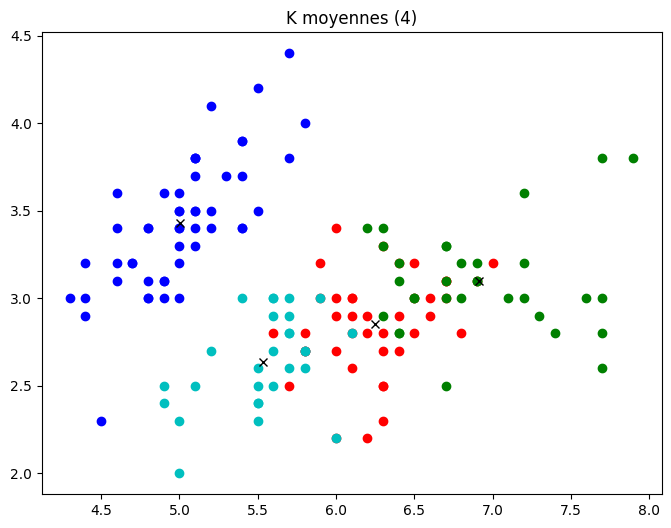

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

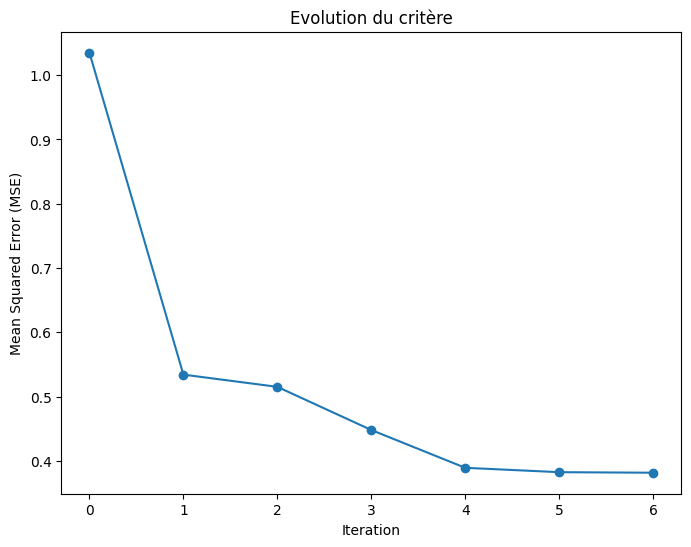

In [6]:
#''' K means '''
iris = datasets.load_iris()
digit = datasets.load_digits() 
X = iris.data#[:, :2]  # we only take the first two features.
y = iris.target
K= 4

Cluster, y, Critere = my_kmeans(X,K,Visualisation = False)


fig = plt.figure(3, figsize=(8, 6))
for k in range(K):
    plt.plot(X[y==k, 0], X[y==k, 1], colors[k%n_colors]+'o')
plt.plot(Cluster[0, :], Cluster[1, :],'kx')
plt.title('K moyennes ('+str(K)+')')
plt.show()

fig = plt.figure(figsize=(8, 6))
plt.plot(Critere, 'o-')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Evolution du critère')
plt

In [ ]:
def evidence_accumulation_clustering(X, K, T, Seuil):
    N = X.shape[0]
    Co_Assoc = np.zeros((N, N))  # Initialize co-association matrix
    y = -np.ones(N, dtype=int)  # Initialize assignment vector with -1 for noise
    n_clusters = 0  # Number of clusters

    # Calculate the co-association matrix
    for t in range(T):
        _, yy, _ = my_kmeans(X, K, Visualisation = False)  # Partition with k-means
        for i in range(N):
            for j in range(N):
                if yy[i] == yy[j]:
                    Co_Assoc[i, j] += 1 / T

    # Final partitioning based on the co-association matrix
    for i in range(N):
        for j in range(N):
            if Co_Assoc[i, j] > Seuil:
                if y[i] != -1 and y[j] != -1:
                    # Merge clusters
                    if y[i] != y[j]:
                        y[y == y[j]] = y[i]
                elif y[i] != -1:
                    y[j] = y[i]  # Assign j to i's cluster
                elif y[j] != -1:
                    y[i] = y[j]  # Assign i to j's cluster
                else:
                    # Create a new cluster
                    y[i] = y[j] = n_clusters
                    n_clusters += 1

    # Renumber clusters starting from 1, set unassigned elements to -1 (noise)
    unique_clusters = np.unique(y[y != -1])
    cluster_map = {old: new+1 for new, old in enumerate(unique_clusters)}
    y = np.array([cluster_map[val] if val in cluster_map else -1 for val in y])
    
    return y

In [ ]:
# Parâmetros para avaliação
T_values = [10, 50, 100, 200]
K_default = 3    # Valor de K, pois temos 3 classes no conjunto IRIS
Seuil_default = 0.5  # Valor padrão do limite de co-associação





